# Dendritic Spine Finding Project, Part 1


In [69]:
# imports
import pandas as pd
import numpy as np
import os

In [70]:
# load in img/numeric file data
img_files = []
num_files = []

for _file in os.listdir('./data/paired'):
    if _file.endswith("jpg"):
        img_files.append(_file)
    elif _file.endswith("txt"):
        num_files.append(_file)

print(img_files[:3])
print(num_files[:3])


['000001.jpg', '000002.jpg', '000003.jpg']
['000001.txt', '000002.txt', '000003.txt']


## Method 1: Using Matplotlib

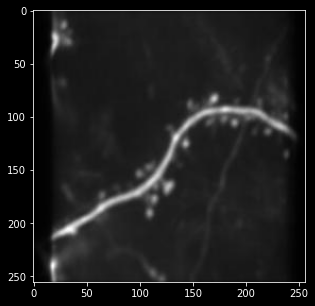

In [71]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
from matplotlib.patches import Rectangle

# load, style, and display test img
img = mpimg.imread(f'./data/paired/{img_files[0]}')
plt.style.use("dark_background")
figure(figsize=(5, 5))
testImg = plt.imshow(img)


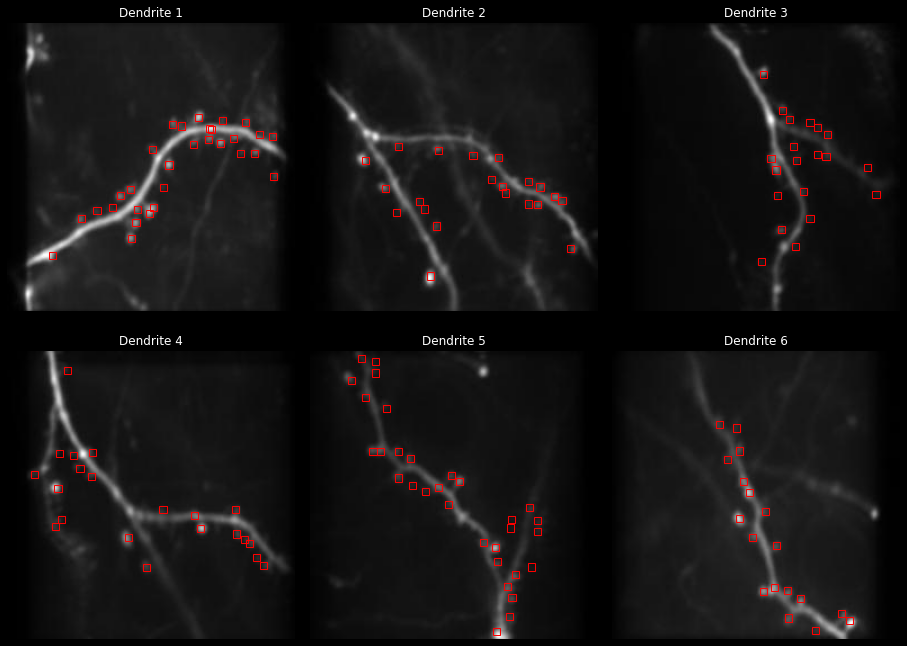

In [106]:
SCALE_FACTOR = 250
BOX_SIZE = 100

def display_images(img_files, num_files, idx=0, numShow=6):
  plt.figure(figsize=(16, 12))
  plt.subplots_adjust(wspace=0.05, hspace=0.01)

  for i, img in enumerate(img_files[:numShow]):
     plt.subplot(231 + idx)
     idx += 1
     img = mpimg.imread(f'./data/paired/{img}')
     num_file = pd.read_csv(f'./data/paired/{num_files[i]}', skiprows=0,
                delim_whitespace=True, header=None, names=['Index', 'X', 'Y', 'W', 'H'])
     for j, spine in num_file.iterrows():
         plt.gca().add_patch(Rectangle((spine['X'] * SCALE_FACTOR, spine['Y'] * SCALE_FACTOR),
                                      spine['W'] * BOX_SIZE, spine['H'] * BOX_SIZE, linewidth=1, edgecolor='r', facecolor='none'))

     plt.title(f"Dendrite {i+1}")
     plt.imshow(img)
     plt.axis('off')

display_images(img_files, num_files)

## Method 2: using TensorFlow (somewhat functional?)
In progress

(256, 256, 3)


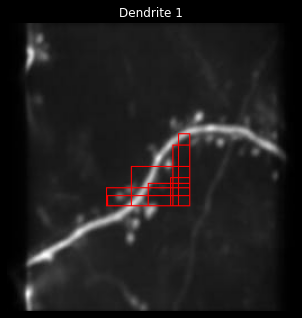

In [331]:
import tensorflow as tf
from PIL import Image

def display_images_with_tf(img_files, num_files, idx=0, numShow=1):
  plt.figure(figsize=(16, 12))
  plt.subplots_adjust(wspace=0.05, hspace=0.01)

  for i, img in enumerate(img_files[:numShow]):
     plt.subplot(231 + idx)
     idx += 1
     img = tf.io.read_file(f'./data/paired/{img}')
     img = tf.image.decode_jpeg(img)
     img = tf.image.convert_image_dtype(
         img, dtype=tf.float32
     )
     colors = np.array([[1.0, 0.0, 0.0]])
     img = tf.expand_dims(img, axis=0)

     num_file = pd.read_csv(f'./data/paired/{num_files[i]}', skiprows=0, delim_whitespace=True, header=None, names=['Index', 'X', 'Y', 'W', 'H'])
     for j, spine in num_file.iterrows():
        box = np.array(
            [spine['X'], spine['Y'], spine['W'] * 10, spine['H'] * 10])
        img = tf.image.draw_bounding_boxes(images=img, boxes=box.reshape([1, 1, 4]), colors=colors)

     img = np.squeeze(img)
     print(img.shape)
     plt.title(f"Dendrite {i+1}")
     plt.imshow(img)
     plt.axis('off')
     plt.show()


display_images_with_tf(img_files, num_files)


## Networking

Number of contours detected: 1


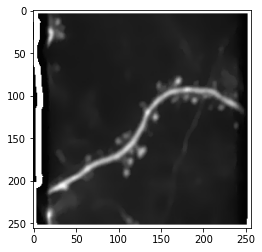

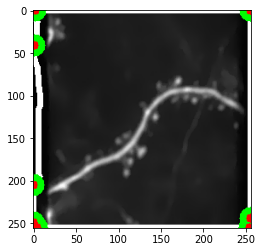

Number of identified spines: 9


In [7]:
import cv2
#Image loading and preprocessing:

img = cv2.imread('img.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.pyrMeanShiftFiltering(img, 5, 11)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, thresh1 = cv2.threshold(gray, 5, 255, 0)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
img1 = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
img1 = cv2.morphologyEx(img1, cv2.MORPH_OPEN, kernel)
img1 = cv2.dilate(img1, kernel, iterations=5)

#Drawing of contours. Some spines were dettached of the main shaft due to
#image bad quality. The main idea of the code below is to identify the shaft
#as the biggest contour, and count any smaller as a spine too.

contours, hierarchy = cv2.findContours(
    img1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print("Number of contours detected: "+str(len(contours)))

cv2.drawContours(img, contours, -1, (255, 255, 255), 6)
plt.imshow(img)
plt.show()

lengths = [len(i) for i in contours]
cnt = lengths.index(max(lengths))

#The contour of the main shaft is stored in cnt

cnt = contours.pop(cnt)

#Finding convexity points with hull:

hull = cv2.convexHull(cnt)

#The next lines are just for visualization. All centroids of smaller contours
#are marked as spines.

for i in contours:

    M = cv2.moments(i)
    centroid_x = int(M['m10']/M['m00'])
    centroid_y = int(M['m01']/M['m00'])
    centroid = np.array([[[centroid_x, centroid_y]]])

    print(centroid)

    cv2.drawContours(img, centroid, -1, (0, 255, 0), 25)
    cv2.drawContours(img, centroid, -1, (255, 0, 0), 10)

cv2.drawContours(img, hull, -1, (0, 255, 0), 25)
cv2.drawContours(img, hull, -1, (255, 0, 0), 10)

plt.imshow(img)
plt.show()

#Finally, the number of spines is computed as the sum between smaller contours
#and protuberances in the main shaft.

spines = len(contours)+len(hull)
print("Number of identified spines: " + str(spines))


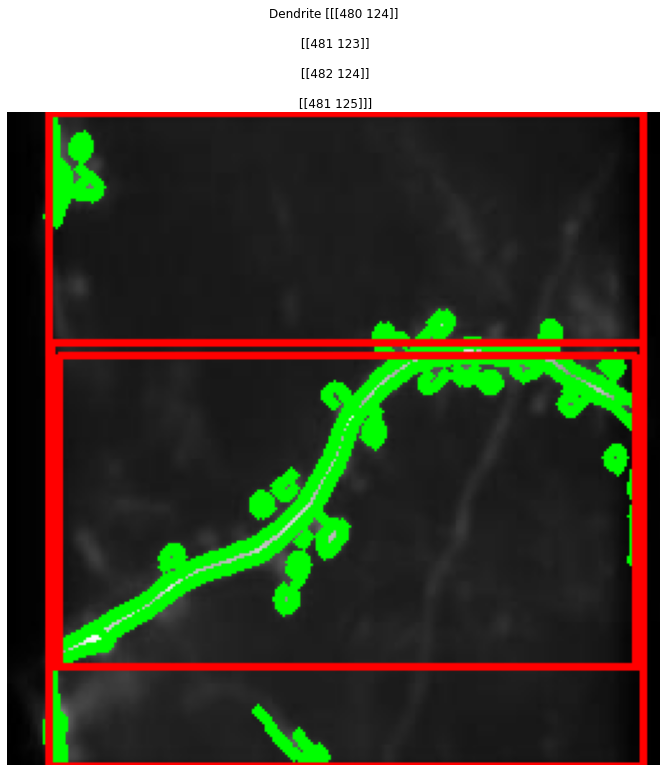

In [28]:
plt.figure(figsize=(16, 12))

image = cv2.imread('img.jpg')
im_bw = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

blur = cv2.GaussianBlur(im_bw, (5, 5), 0)
im_bw = cv2.Canny(blur, 10, 90)

contours, hierarchy = cv2.findContours(
    im_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image, contours, -1, (0, 255, 0), 3)

try:
    hierarchy = hierarchy[0]
except:
    hierarchy = []

height, width, _ = image.shape
min_x, min_y = width, height
max_x = max_y = 0

# computes the bounding box for the contour, and draws it on the frame,
for contour, hier in zip(contours, hierarchy):
    (x, y, w, h) = cv2.boundingRect(contour)
    min_x, max_x = min(x, min_x), max(x+w, max_x)
    min_y, max_y = min(y, min_y), max(y+h, max_y)
    if w > 80 and h > 80:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

if max_x - min_x > 0 and max_y - min_y > 0:
    cv2.rectangle(image, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)

plt.title(f"Dendrite {i+1}")
plt.axis('off')
plt.imshow(image)
plt.show()
# img = cv2.imread('img.jpg')  # Reading Source Image

# # Converting to Graysacale For Efficiency in Computation
# image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# plt.imshow(image)
# plt.show()

# contours, _ = cv2.findContours(
# 	image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Finding Contours

# # Finding No. Of Contours Detected i.e, No. of Shapes
# print("no of shapes: {0}".format(len(contours)))

# #Drawing Rectangle Contours ========================================
# for cnt in contours:
# 	rect = cv2.minAreaRect(cnt)
# 	box = cv2.boxPoints(rect)
# 	box = np.int0(box)
# 	img = cv2.drawContours(img, [box], 0, (0, 0, 255))  # BGR_Color_Sequence
# #===================================================================

# #finding center of the recognized shapes ===========================
# for cnt in contours:
# 	M = cv2.moments(cnt)
# 	cx = int(M['m10']/M['m00'])
# 	cy = int(M['m01']/M['m00'])
# 	center = (cx, cy)
# 	print("Center coordinate: "+str(center))
# 	radius = 5
# 	cv2.circle(img, (cx, cy), radius, (0, 255, 255), -1)
# #===================================================================

# #Drawing polygin Contours ==========================================
# 	epsilon = 0.01*cv2.arcLength(cnt, True)
# 	approx = cv2.approxPolyDP(cnt, epsilon, True)
# 	img = cv2.drawContours(img, [approx], 0, (0, 255, 0), 2)
# #===================================================================

# plt.imshow(img)
# plt.show()
